In [1]:
using Gen
using Random
using Statistics: mean, std
using StatsBase
using BenchmarkTools
using JLD
import PyPlot
plt = PyPlot.plt
plt.style.use("seaborn")

include("plotting.jl");
include("code_from_part_1.jl");

display(HTML("<style>.rendered_html.text_cell_render {max-width:700px; }</style>"));

HTML{String}("<style>.rendered_html.text_cell_render {max-width:700px; }</style>")

**Code from Part 1:** This notebook is based on the models derived in the first part. 
We included the relevant source code in the cell above. The main pieces we will use here are
the base distribution `G0`, the data distributions `F(𝜙)`,
the mixture model `crp_mixture_model`, and some helper functions like `relabel_tables`.


In [2]:
display(@doc F)
display(@doc G0)
display(@doc crp_mixture_model)
display(@doc relabel_tables)
display(@doc get_obs)

```
F(phi)
```

Family of data distributions conditioned  on cluster parameters. 


```
G0()
```

Basedistribution over cluster parameters.


```
(c, phi, x) = crp_mixture_model(T::Int, 
                                α::Float64, 
                                F::Union{Distribution,DynamicDSLFunction}, 
                                G0::Union{Distribution,DynamicDSLFunction})
```

Defines a non-parametric mixture model. Cluster assignments are chosen according to a CRP  with concentration parameter `α`, cluster parameters are chosen from a base distribution `G0`, and the data are generated from a family of distributions `F`.


```
tr = relabel_tables(tr::Gen.Trace)
```

Relabels the tables according their allocation, i.e.  it changes `c` and the `phi` as if the were  constructed by the crp model without changing  the cluster memberships. 


```
get_obs(x)
```

Creates a choicemap with data constraints given by `x`. Depends on the trace structure of the data models. 


# Approximate Inference

In this part of the tutorial I define an approximate inference model &mdash; mostly to get comfortable with Gen. At some point it would be nice to implement more sophisticated models as described in (Neal,2000) for instance and aim for performance. Cf. **Part 1** for references and other resources.

Let us start off be indentifying all the pieces we need. Depending on our choice of priors and data model we can then argue how to approximate them. We define a Markov chain whose state is given by the assignments $c_1,\ldots,c_T$ and which is updated via Gibbs sampling using the conditional distributions

$$\tag{$\ast$}
\begin{eqnarray}
        p(c_t = j \mid c_{-t}, y) 
            &=& \eta \cdot \color{}{p( y_t \mid c, y_{-t} )} \cdot  \color{}{p(c_t = j \mid c_{-t})} \\ 
            &=& \eta \cdot 
            \color{blue}{\int F( y_t ; \phi_{c_t}) \ p(\phi_{c_t} | y_{-t},c ) \ d\phi_{c_t}} \cdot 
            \color{green}{p(c_t =j \mid c_{-t})}.
\end{eqnarray}
$$

Note that that last term, $p(c_t \mid c_{-t})$, corresponds to the CRP kernel defined above, i.e.

$$
        \color{green}{p(c_t = j \mid c_{-t})}  \propto
        \begin{cases} 
         n_{j,-t}  & j = c_s, \text{for some } s\neq t \\
        \alpha    & \text{otherwise}.
    \end{cases}
$$

We are left with computing the marginal distribution describing the first term (not counting the normalizeing constant $\eta$).

**Approximation of the marginal distribution**

For now I assume we cannot analytically compute the term $\color{blue}{\int F( y_t ; \phi_{c_t}) \ p(\phi_{c_t} | y_{-t},c ) \ d\phi_{c_t}}$.
Thus we have to approximate the term otherwise, using Monte Carlo approximation, for instance.
In order to do so we need to sample from the posterior $p(\phi_{c_t} | y_{-t},c )$.
This is hard in general. But what we can do is use importance sampling to "mimic" samples from it. We have

$$\tag{$\ast\ast$}
p(\phi_{c_t} | y_{-t},c ) = p(\phi \mid y_{s\neq t,c_s=c_t} ) 
    = \frac{\color{red}{   p(y_{s\neq t,c_s=c_t} \mid \phi) \ p(\phi)}}{{\int p(y_{s\neq t,c_s=c_t} \mid \phi) \ p(\phi) \ d\phi} }.
$$ 

Expressing the posterior in this way tells how to model it using Gen (cf. the Gen function `data_model_with_prior` which models the part higlighted in red).
We then use a proposal distribution $\color{}{q(\phi \mid y_{t\neq i, t=c_i})}$ to create a series of samples

$$
    \phi_m \sim q(\phi \mid y_{t\neq i, t=c_i})
$$

with normalized importance weights $w_m = \tfrac{\tilde w_m}{\sum \tilde w_m}$, where
$
    \tilde w_m=\tfrac{p(y_{t\neq i, t=c_i} \mid \phi) \ p(\phi)}{q(\phi \mid y_{t\neq i, t=c_i})}.
$
The poposal distribution is modeled as `phi_proposal` below.
Finally we approximate the marginal likelihood as

$$\tag{$\ast\ast\ast$}
    \color{blue}{\int F( y_t ; \phi_{c_t}) \ p(\phi_{c_t} | y_{-t},c ) \ d\phi_{c_t}}
        \approx 
            \sum_m F(y_i ; \phi_m) \cdot w_m.
$$


<!-- which are then weighted by by normalizing $\tilde w_m=\tfrac{p(y_{t\neq i, t=c_i} \mid \phi) \ p(\phi)}{q(\phi \mid y_{t\neq i, t=c_i})}$.

compute weighted samples $\{ (\phi_m, w_m)\}$ with $\phi_m \sim q(\phi \mid y_{t\neq i, t=c_i})$ and weights $w_m$ given by normalizing $\tilde w_m=\tfrac{p(y_{t\neq i, t=c_i} \mid \phi) \ p(\phi)}{q(\phi \mid y_{t\neq i, t=c_i})}$.
 -->

Might be impractical...nevertheless no assumptions etc...

In [3]:
"""
    (phi, x) = data_model_with_prior(n::Int, F, G0)

Data model described in (∗∗) without the normalizing integral.
"""
@gen function data_model_with_prior(n::Int, F, G0)
    phi = @trace(G0(), :phi)
    
    x = []
    for s=1:n
        x_s = @trace(F(phi), :x => (:x, s))
        push!(x, x_s)
    end
    
    return phi, x
end;

In [4]:
"""
    phi_proposal(x, G0)

Poposal for the cluster parameters in `data_model_with_prior` 
given the datapoints generated from the cluster. This function should
be defined with respect to `G0` and `F`.
"""
@gen function phi_proposal(x, G0)
    if length(x) > 0
        @trace(normal(mean(x), .2), :phi => :mean)
        
        # Computing the variance needs a 
        # few entries to work well
        if length(x) < 5 
            @trace(inv_gamma(5., 4.),  :phi => :std)
        else
            a = 20.
            b = std(x)*(a-1)
            @trace(inv_gamma(a, b),  :phi => :std)
        end
    else
        @trace(G0(), :phi)
    end
end;

In [5]:
argmax(a; dims=1) = findmax(a; dims=dims)[2][1];

"""
    phi_map_estimate(x, F, G0; num_samples=5)

Maximum a poseriori estimate of the cluster parameters.
"""
function phi_map_estimate(x, F, G0; num_samples=20)
    obs = get_obs(x)
    trs, ws, = importance_sampling(data_model_with_prior, (length(x), F, G0), obs, 
                                              phi_proposal,          (x, G0), num_samples)
    tr = trs[argmax(ws)]
    return tr[:phi]
end;

In [6]:
"""
    marginal_lh(t, j, y, c, F, G0; num_samples)

Marginal likelihood estimate in Equation (∗∗∗).

Note, I assume that you defined the function `set_obs`, 
which sets the data choices in a `data_model_with_prior` trace.
"""
function marginal_lh(t, j, y, c, F, G0; num_samples)
    
    if j == nothing
        cond = falses(length(y)) 
    else
        cond = c .== j
        cond[t] = false
    end 
    
    y_tj = y[cond]
    
    obs = get_obs(y_tj)
    
    trs, ws, = importance_sampling(data_model_with_prior, (length(y_tj), F, G0), obs, 
                                              phi_proposal,          (y_tj, G0), num_samples)
    phi = [tr[:phi] for tr in trs]
    fs  = [Gen.assess(F, (phi[m],), choicemap(:x => y[t]))[1]  for m=1:num_samples]
    
    return sum(exp.(fs .+ ws))
end;

In [7]:
"""
    table_counts(c)

Counts the number of assigments to the maximum 
possible number of tables (length(c))
"""
function table_counts(c)
    n = zeros(length(c))
    for i in c
        n[i] += 1
    end
    return n
end;


raw"""
    set_c!(upd, t, j) 

Sets an assignment constraint in the choicemap to 
$c_t = j$. 
"""
function set_c!(upd, t, j) 
    upd[:c => (:c,t)] = j
end


"""
    set_phi!(upd, i, phi)

Sets the i'th cluster paramete in the choicemap to phi. 
"""
function set_phi!(upd, i, phi)
    upd[:phi => (:phi, i) => :mean] = phi[1]
    upd[:phi => (:phi, i) => :std]  = phi[2]
end;

In [8]:
"""
    naive_gibbs_kernel(tr, α, F, G0, mlh_samples)    

Resamples each table assignment once according to the probability
given in (∗).

Note, I assume that you defined the functions `set_c!` `set_phi!` to update
a choicemap of updates for a `crp_mixture_model` trace.

"""
function naive_gibbs_kernel(tr, α, F, G0, mlh_samples)    
    
    c, phi, x = get_retval(tr)
    # Rem: Holy shit that took a while, c is a reference
    # i.e. changing c changes the return value of the trace!
    c   = copy(c) 
    phi = copy(phi)
    
    k   = length(phi)
    T   = length(c)
    n   = table_counts(c)
    upd = choicemap()
    
    for t=1:T
        #
        # Pretend cust t hasn't arrived yet and
        # adjust counts and cluster number
        #
        n[c[t]] -= 1    
        if n[c[t]] == 0
            k -= 1
            delete!(phi, c[t])
        end
    
        #
        # Sample from p(c_t | c_not_t, y)
        #
        mlh = j -> marginal_lh(t, j, x, c, F, G0; num_samples=mlh_samples)
        
        zero_mlh = α/(T-k) * mlh(nothing)
        pr = [ n[j] != 0 ? n[j] * mlh(j) : zero_mlh  for j=1:T ]
        pr = pr./sum(pr)
        c[t] = categorical(pr)

        #
        # Assign customer to newly sampled table and
        # adjust counts and cluster number
        #
        n[c[t]] += 1  
        if n[c[t]] == 1
            k += 1
            phi[c[t]] = G0()
        end
        
        #
        # Record the changes for the trace update
        #
        set_c!(upd, t, c[t])

    end
    
    for i in Set(c)
        # This should be done with the samples in the mlh to save time...but y[t] is not part of it?!
        phi[i] = phi_map_estimate(x[c.==i], F, G0; num_samples=mlh_samples) 
        set_phi!(upd, i, phi[i])
    end
    
    new_tr, w,  = update(tr, upd)
    relabled_tr = relabel_tables(new_tr)
    
    return relabled_tr
end;

**Runtime** `naive_gibbs_kernel`

For each customer $t=1,\ldots,T$ and potential table $j=1,...,k_{t-1} + 1$ we compute $p(c_t = j \mid c_{-t}, y)$ as described in $(\ast)$. The number of tables $k_{t-1}$ varies and theoretically can go up $T$ &mdash; in fact the way I implement it assumes that there are T (potentially empty) tables. We approximate the marginal in $(\ast)$ using importance sampling, which scales with the number of samples, $s$ say. Thus the runtime is

$$
    f(\text{t}) = O(s \cdot T^2).
$$

In [9]:
"""
    naive_gibbs_inference(args, obs; steps=1, mlh_samples=1)

Runs a number of Gibbs steps and returns the corresponding traces and
scores.
"""
function naive_gibbs_inference(args, obs; steps=1, mlh_samples=1)
    
    (T, α, F, G0) = args
    tr, = Gen.generate(crp_mixture_model, args, obs) 
    c, phi, x = get_retval(tr)
    k  = length(phi)
    w  = get_score(tr)
    ws = [w]
    trs = [tr]
    
    println("Naive Gibbs inference:")
    println("...0\t k = $(k), \tw=$(get_score(tr))") 
    for g=1:steps
        
        tr = naive_gibbs_kernel(tr, α, F, G0, mlh_samples) 
        w  = get_score(tr)
        c, phi, x = get_retval(tr)
        push!(trs, tr)
        push!(ws, w)
        if g%5 == 0 || g==steps
            println("...$(g)\t k = $(length(phi)), \tw=$(w)") 
        end
        
    end
    
    return trs, ws
end;

# Example

In [10]:
function render_mixture(x,c)
    fig, axs = plt.subplots(1,2, figsize=(8,1), gridspec_kw=Dict("width_ratios" => [8, 1]));
    for i in Set(c)
        axs[1].hist(x[c.==i], bins=-10:0.25:10, alpha=0.8, label="$(i)"); 
    end
    axs[2].hist(c, bins=1:length(Set(c))+1, width=0.8);
    axs[1].legend()
end;

┌ Warning: JLD incorrectly extends FileIO functions (see FileIO documentation)
└ @ FileIO /Users/mirko/.julia/packages/FileIO/ajK7j/src/loadsave.jl:210


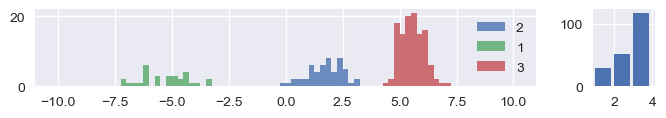

T = 200


In [12]:
data = load("example_data.jld")
x = data["x"]
c = data["c"]
obs = get_obs(x);
T = length(x)
println("T = $(T)")

render_mixture(x,c);

Naive Gibbs inference:
...0	 k = 5, 	w=-2134.3713897184225
...5	 k = 4, 	w=-548.0448891336385
...10	 k = 4, 	w=-454.2785865597777
...15	 k = 4, 	w=-480.119857572856
...20	 k = 5, 	w=-519.459241835415
...25	 k = 8, 	w=-584.9787076070559
...30	 k = 6, 	w=-615.6554855670704
...35	 k = 4, 	w=-448.56160263407656
...40	 k = 6, 	w=-698.6566025888641
...45	 k = 4, 	w=-448.0260059706952


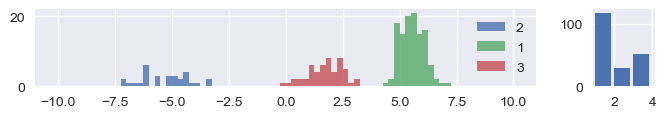

...50	 k = 3, 	w=-428.5191615501566


In [15]:
trs, ws = naive_gibbs_inference((T, .5, F, G0), obs; steps=50, mlh_samples=5);

tr = trs[end]
c, phi, x = get_retval(tr)
render_mixture(x,c);

In [16]:
using Interact
plt.ion()

In [17]:
# Rem: For whatever julia reason 
#      you might have to reload the page
#      for the widget to work

fig = plt.figure(figsize=(8,2));
@manipulate for t in 1:length(trs); 
PyPlot.withfig(fig) do
        
    tr = trs[t]
    c, phi, x = get_retval(tr)
            
    plt.subplot(131)
    for i in Set(c)
        mu, std = phi[i]
            
        plt.hist(x[c.==i], bins=-8:0.5:8, alpha=0.5, label="$(i)",  color="C$(i)"); 
        plt.scatter(mu, -1, c="C$(i)", alpha=0.5)
        plt.plot([mu - std, mu + std], [-1, -1],  c="C$(i)", marker=".", alpha=0.5)
    end
        
    plt.subplot(132)
    plt.hist(c, bins=1:length(Set(c))+1, width=0.8);
    plt.xticks(1.5:1:length(Set(c))+0.5 ,1:length(Set(c)))
        
    plt.subplot(133)
    plt.plot(1:length(ws), ws);
    plt.scatter(t,ws[t], clip_on=true);
    plt.tight_layout()
        
end end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["t"], Dict{Symbol,Any}(:className => "interact ",:style => Dict{Any,Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol,Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol,Any}(:max => 51,:min => 1,:attributes => Dict{Any,Any}(:type => "range",Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient" => "horizontal"),:step => 1,:className => "slider slider is-fullwidth",:style => Dict{Any,Any}()))], Dict{Symbol,Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol,Any}(:className => "interact-flex-row-right"))], Dict{Symbol,Any}(:className => "interact-flex-row interact-widget")), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing),"index" => (Observable{Int64} with 2 listeners. Value:
26, nothing)), Set(String[]), nothing, Asset[Asset("js", "knockout", "/Users/mirko/.julia/packages/Knockout/IP1uR/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/Users/mirko/.julia/packages/Knockout/IP1uR/src/../assets/knockout_punches.js"), Asset("js", nothing, "/Users/mirko/.julia/packages/InteractBase/Zfu5P/src/../assets/all.js"), Asset("css", nothing, "/Users/mirko/.julia/packages/InteractBase/Zfu5P/src/../assets/style.css"), Asset("css", nothing, "/Users/mirko/.julia/packages/Interact/SbgIk/src/../assets/bulma_confined.min.css")], Dict{Any,Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(sz_max:32,sz_curr:0), Set(AbstractConnection[]), Base.GenericCondition{Base.AlwaysLockedST}(Base.InvasiveLinkedList{Task}(Task (runnable) @0x000000013188e410, Task (runnable) @0x000000013188e410), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"1\",\"2\",\"3\",\"4\",\"5\",\"6\",\"7\",\"8\",\"9\",\"10\",\"11\",\"12\",\"13\",\"14\",\"15\",\"16\",\"17\",\"18\",\"19\",\"20\",\"21\",\"22\",\"23\",\"24\",\"25\",\"26\",\"27\",\"28\",\"29\",\"30\",\"31\",\"32\",\"33\",\"34\",\"35\",\"36\",\"37\

<hr style="border:10px solid black"> </hr>